# Setup

In [17]:
# import your standard packages
%run ../../global_tools/start.py

# import your local functions
from local_functions import *

# make sure the figures plot inline rather than at the end
%matplotlib inline

Default libraries loaded.


# Paths and Parameters

In [18]:
# these are for grouping into the IOD years since the effects are 
# not confined to a single year. You chose this to have an even 
# number of months around the IOD peak..but now you left it in
# line with the SLA plots that start in 06 and end in 05
IODyear_begin = '-06-01' # month-day of IOD year
IODyear_end = '-05-31' # month-day of year AFTER IOD year

bounds_AS = [68,79,3,20]
bounds_wBoB = [79,87,2,21]
bounds_BoB = [87,100,0,23]

#coastal mask bounds 
cm_bounds = [48.5, 102.5,-1.5, 33]

# Get Data

In [19]:
ds_SLA = xr.open_dataset('../data/sla_processed.nc')
ds_SLA

<xarray.Dataset>
Dimensions:           (day_time: 10013, lat: 138, loc_list: 5, lon: 216, month: 12, no_stations: 367, time: 329)
Coordinates:
  * lon               (lon) float64 48.62 48.88 49.12 ... 101.9 102.1 102.4
  * lat               (lat) float64 -1.375 -1.125 -0.875 ... 32.38 32.62 32.88
  * time              (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2020-05-01
  * day_time          (day_time) datetime64[ns] 1993-01-01 ... 2020-05-31
  * month             (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * no_stations       (no_stations) float64 1.0 2.0 3.0 ... 365.0 366.0 367.0
  * loc_list          (loc_list) int64 0 75 225 313 366
Data variables:
    daily_sla         (day_time, lat, lon) float64 ...
    mon_sla           (time, lat, lon) float64 ...
    mon_sla_mon_clim  (month, lat, lon) float64 ...
    mon_sla_mon_anom  (time, lat, lon) float64 ...
    sta_loninds       (no_stations) int64 ...
    sta_latinds       (no_stations) int64 ...
    sta_lon           (no_station

In [20]:
# load DMI data
ds_DMI= xr.open_dataset('../data/dmi_processed.nc')

# lists of positive iod years for now taken from sources above 1994-2018 unsure after 2016
posIODyears = list(np.array(ds_DMI.pos_IOD_years)) #[1994,1997,2006,2012,2015]
negIODyears = list(np.array(ds_DMI.neg_IOD_years)) #[1996,1998,2001,2010,2014,2016]
neuIODyears = list(np.array(ds_DMI.neu_IOD_years)) # [1995,1999,2000,2002,2003,2004,2005,2007,2008,2009,2011,2012,2013]

sposIODyears = list(np.array(ds_DMI.spos_IOD_years)) 
snegIODyears = list(np.array(ds_DMI.sneg_IOD_years)) 

wposIODyears = list(np.array(ds_DMI.wpos_IOD_years)) 
wnegIODyears = list(np.array(ds_DMI.wneg_IOD_years)) 

ds_DMI

<xarray.Dataset>
Dimensions:          (negyears: 10, neuyears: 40, posyears: 13, snegyears: 6, sposyears: 6, time: 744, wnegyears: 4, wposyears: 7)
Coordinates:
  * time             (time) datetime64[ns] 1958-06-01 1958-07-01 ... 2020-05-01
  * posyears         (posyears) int64 1961 1963 1967 1972 ... 2015 2018 2019
  * negyears         (negyears) int64 1960 1964 1970 1971 ... 1998 2010 2016
  * neuyears         (neuyears) int64 1958 1959 1962 1965 ... 2014 2017 2020
  * sposyears        (sposyears) int64 1961 1972 1994 1997 2006 2019
  * snegyears        (snegyears) int64 1960 1964 1970 1996 1998 2016
  * wposyears        (wposyears) int64 1963 1967 1977 1982 2012 2015 2018
  * wnegyears        (wnegyears) int64 1971 1975 1992 2010
Data variables:
    dmi              (time) float64 ...
    dmi_3mo_runmean  (time) float64 ...
    pos_IOD_years    (posyears) int64 1961 1963 1967 1972 ... 2015 2018 2019
    neg_IOD_years    (negyears) int64 1960 1964 1970 1971 ... 1998 2010 2016
    neu

In [21]:
xx,yy = np.meshgrid(np.array(ds_SLA.lon),np.array(ds_SLA.lat))
xx = xx.flatten()
yy = yy.flatten()
mask = mask_coast(xx,yy,np.array(cm_bounds))
# mask = np.reshape(mask,xx.shape)
xx = xx[mask]
yy = yy[mask]

# subset and SLA DMI to CHL years 1997+ and by season

In [30]:
time_slice = slice('1993-01-01','2020-05-01')

dmi = ds_DMI['dmi'].sel(time = time_slice)
dmi

<xarray.DataArray 'dmi' (time: 329)>
array([-0.049216,  0.022297, -0.166317, ..., -0.306877,  0.137829,  0.533618])
Coordinates:
  * time     (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2020-05-01

In [23]:
season = np.ones(dmi.time.shape)
for tt in range(dmi.time.shape[0]):
    mm = dmi.time.dt.month[tt]
    if (mm == 12) | (mm == 1) | (mm == 2) | (mm == 3) | (mm == 4) | (mm == 5):
        season[tt] = 0        

# Seasonal Correlation SLA vs DMI

In [28]:
n = len(ds_SLA.lat)
m = len(ds_SLA.lon)
    
SLOPE_sla_dmi = np.full([n,m,2],np.nan)
INTERCEPT_sla_dmi = np.full([n,m,2],np.nan)
R_VALUE_sla_dmi = np.full([n,m,2],np.nan)
P_VALUE_sla_dmi = np.full([n,m,2],np.nan)
STD_ERR_sla_dmi = np.full([n,m,2],np.nan)

for ss in range(2):
    with tqdm(total=n * m) as pbar:
        for ii,jj in itertools.product(np.arange(n),np.arange(m)):
            tempvar1 = np.array(ds_SLA.mon_sla_mon_anom[:,ii,jj])
            tempvar2 = np.array(dmi)
            
            #subset for season
            ind = (season == ss)
            tempvar1 = tempvar1[ind]
            tempvar2 = tempvar2[ind]
            
            #subset for season
            

            nanmask = ~np.isnan(tempvar1)

            if tempvar1[nanmask].size != 0:
                slope, intercept, r_value, p_value, std_err=stats.linregress(tempvar1[nanmask],tempvar2[nanmask])

                SLOPE_sla_dmi[ii,jj,ss] = slope
                INTERCEPT_sla_dmi[ii,jj,ss] = intercept
                R_VALUE_sla_dmi[ii,jj,ss] = r_value
                P_VALUE_sla_dmi[ii,jj,ss] = p_value
                STD_ERR_sla_dmi[ii,jj,ss] = std_err

            pbar.update(1)

100%|██████████| 29808/29808 [02:07<00:00, 233.87it/s]


# Plot

/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in less_equal
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in less_equal
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in less_equal
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in less_equal


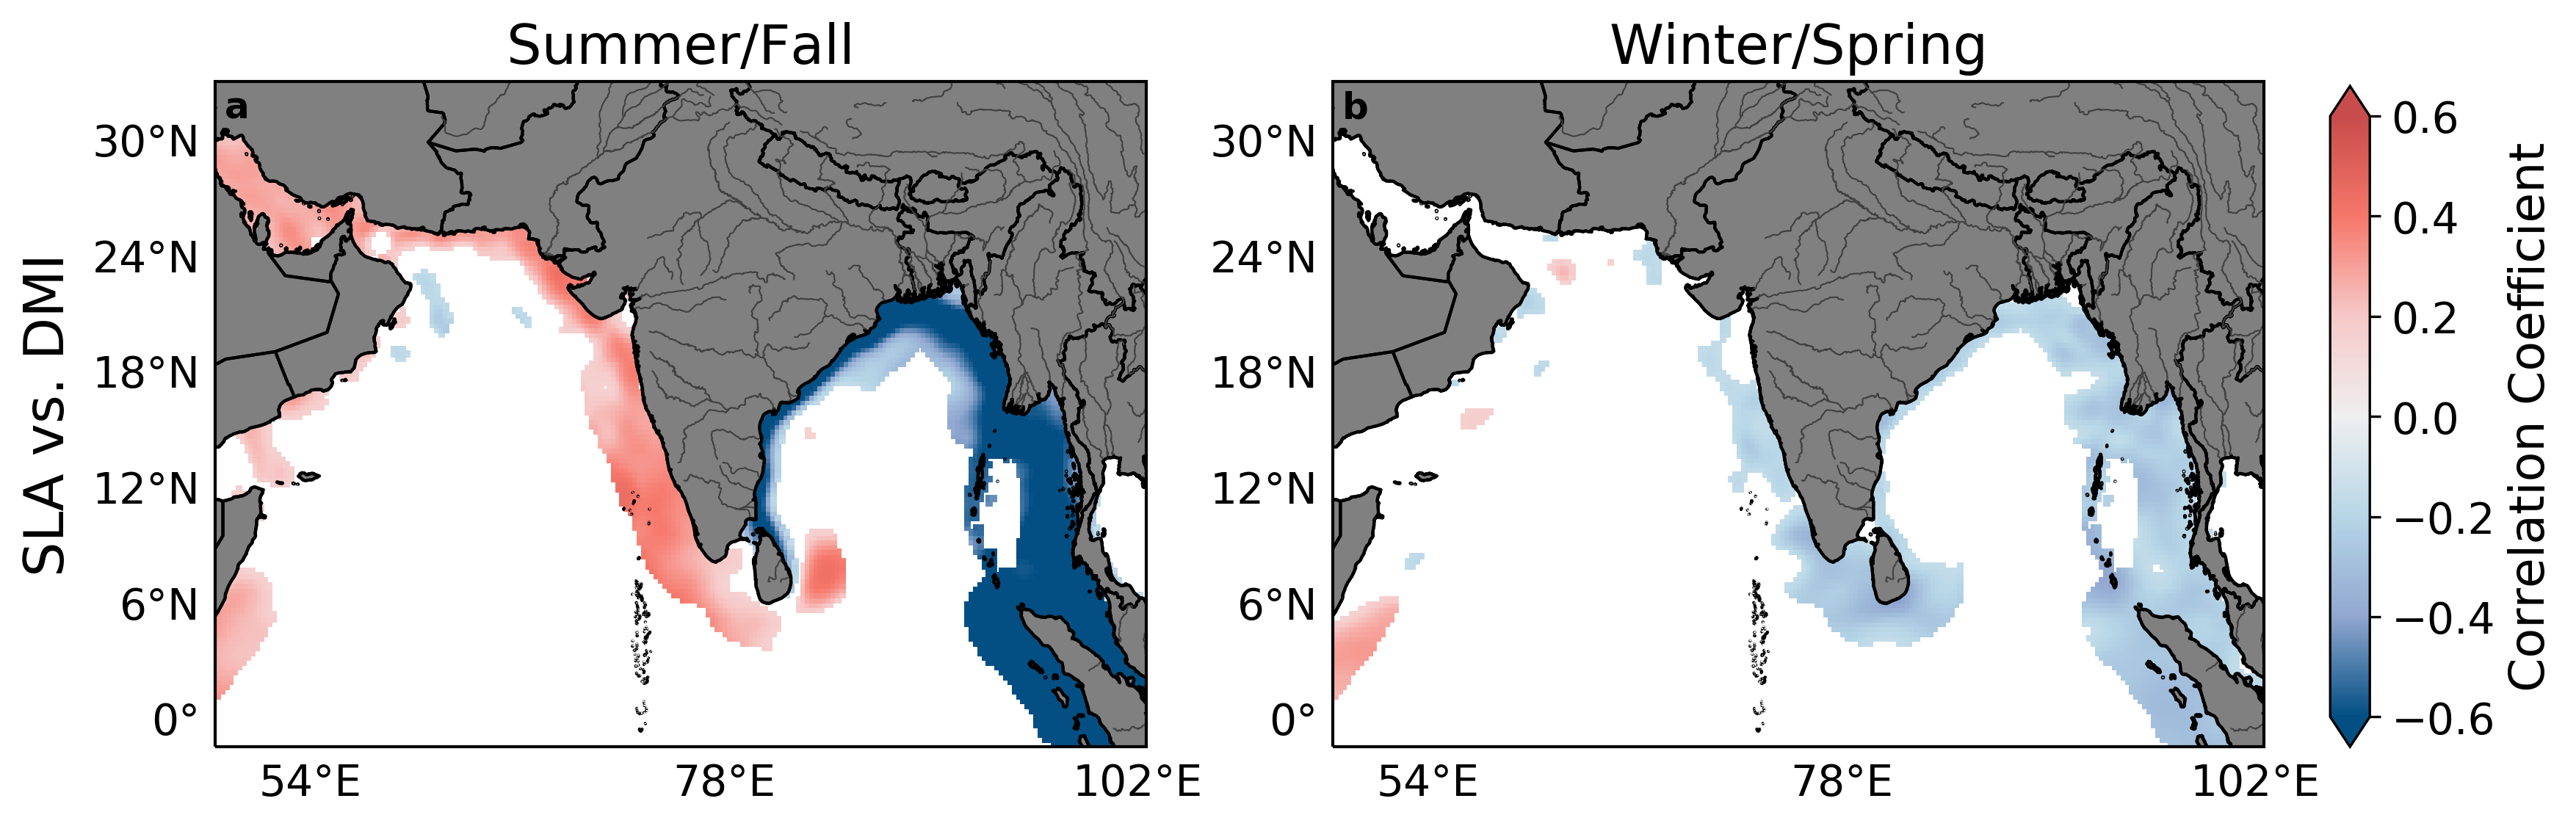

In [29]:
fig = plt.figure(figsize=(12,4),dpi=300)
sz = 5

cmin_corr = -0.6
cmax_corr = 0.6

cmap = get_continuous_cmap(['#000000','#7A378B','#42d4f4','#D3D3D3','#DcDcDc','#F0F0F0'],
                           [0,0.4,0.6,0.8,0.9,1])

cmap2 = get_continuous_cmap(['#034f84','#92a8d1','#b7d7e8','#f0f0f0','#f7cac9','#f7786b','#c94c4c'])

params = {'legend.fontsize': 14,
         'axes.labelsize': 16,
         'axes.titlesize': 18,
         'xtick.labelsize':14,
         'ytick.labelsize':14}
pylab.rcParams.update(params)

##############################################################

ax = fig.add_subplot(121,projection= ccrs.PlateCarree())
tmp = R_VALUE_sla_dmi[:,:,1].flatten()[mask]
hatch_var = P_VALUE_sla_dmi[:,:,1].flatten()[mask]
hatch_mask = hatch_var <= 0.5
p = ax.scatter(xx[hatch_var <= 0.05],yy[hatch_var <= 0.05],c = tmp[hatch_var <= 0.05],marker='s',s= sz,linewidth=0,
               cmap=cmap2,transform=ccrs.PlateCarree(),vmin=cmin_corr,vmax=cmax_corr)
#                norm=mpl.colors.SymLogNorm(linthresh=0.1, linscale=1,vmin=cmin_corr,vmax=cmax_corr))
ax.set_title('Summer/Fall')
ylabel_map(ax,label='SLA vs. DMI')
g = add_land(ax, countries = True, rivers = True)
g.xlocator = mticker.FixedLocator([54,78,102])
g.xlabel_style = {'size': 14}
g.ylabel_style = {'size': 14}
add_letter(ax, 'a')

ax = fig.add_subplot(122,projection= ccrs.PlateCarree())
tmp = R_VALUE_sla_dmi[:,:,0].flatten()[mask]
hatch_var = P_VALUE_sla_dmi[:,:,0].flatten()[mask]
hatch_mask = hatch_var <= 0.5
p = ax.scatter(xx[hatch_var <= 0.05],yy[hatch_var <= 0.05],c = tmp[hatch_var <= 0.05],marker='s',s= sz,linewidth=0,
               cmap=cmap2,transform=ccrs.PlateCarree(),vmin=cmin_corr,vmax=cmax_corr)
#               norm=mpl.colors.SymLogNorm(linthresh=0.1, linscale=1,vmin=cmin_corr,vmax=cmax_corr))
g = add_land(ax, countries = True, rivers = True)
g.xlocator = mticker.FixedLocator([54,78,102])
g.xlabel_style = {'size': 14}
g.ylabel_style = {'size': 14}
ax.set_title('Winter/Spring')
add_letter(ax, 'b')

add_single_vert_cbar(fig,p,'Correlation Coefficient', extend = 'both')